# Empirical data on rubisco and CA

This notebook uses empirical data collected in Davidi et al. 2018 (Chemical Reviews) and Flamholz et al. 2019 (Biochemistry) to estimate reasonable ranges for $k_{cat} / K_M$ for carbonic anhydrase and rubisco. These values are then used to reason about the co-limitation of autotrophy by CO2 and HCO3-. 

In [1]:
mkdir -p ../figures/sup_fig_enzyme_kinetics

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

greens = sns.color_palette('Greens_r')
purples = sns.color_palette('Purples_r')
greys = sns.color_palette('Greys_r')

In [3]:
# Load data from Davidi et al. 2018 (Chemical Reviews) to inspect reasonable CA rate range.
davidi_df = pd.read_excel("../data/EnzymeKinetics/Davidi2018_enz_kinetics.xlsx")
# There is an error - the KMs are reported as mM but they are clearly uM:
# 2000 mM is not a measureable KM for CO2. 
davidi_df['KM (uM)'] = davidi_df['KM [mM]']
davidi_df['kcat/KM (/s /uM)'] = davidi_df['kcat / KM [s-1 M-1]'] * 1e-6
davidi_df.head()

,EC Number,Reactant ID (KEGG Compound ID),Organism,Direction,kcat [s-1],KM [mM],kcat / KM [s-1 M-1],KM (uM),kcat/KM (/s /uM)
0,3.1.4.16,C02353,Escherichia coli,forward,2.95,17745.0,166.244012,17745.0,0.000166
1,3.1.4.16,C06194,Escherichia coli,forward,2.95,1600.0,1843.750000,1600.0,0.001844
2,3.1.4.16,C02353,Fusarium culmorum,forward,NaN,300.0,NaN,300.0,NaN
3,3.1.4.16,C02354,Fusarium culmorum,forward,NaN,600.0,NaN,600.0,NaN
4,3.1.4.16,C02355,Fusarium culmorum,forward,NaN,2000.0,NaN,2000.0,NaN


In [4]:
# Grab CA data in hydration direction (CO2 substrate)
mask = np.logical_and(
    davidi_df['EC Number'] == '4.2.1.1',
    np.logical_not(np.isnan(davidi_df['kcat/KM (/s /uM)'])))
mask = np.logical_and(davidi_df.Direction == 'backward', mask)
mask = np.logical_and(davidi_df['Reactant ID (KEGG Compound ID)'] == 'C00011', mask)
CA_df = davidi_df[mask]

# Drop the insane outlier - clearly there is some problem with this data point. 
CA_df = CA_df[CA_df.Organism != 'Leishmania chagasi']
CA_df.head(5)

,EC Number,Reactant ID (KEGG Compound ID),Organism,Direction,kcat [s-1],KM [mM],kcat / KM [s-1 M-1],KM (uM),kcat/KM (/s /uM)
803,4.2.1.1,C00011,Acipenser gueldenstaedtii,backward,1200000.0,10900.0,1.100917e+08,10900.0,110.091743
804,4.2.1.1,C00011,Anguilla anguilla,backward,25000.0,21720.0,1.151013e+06,21720.0,1.151013
805,4.2.1.1,C00011,Astrosclera willeyana,backward,900000.0,4000.0,2.250000e+08,4000.0,225.000000
807,4.2.1.1,C00011,Candida albicans,backward,800000.0,8200.0,9.756098e+07,8200.0,97.560976
809,4.2.1.1,C00011,Chionodraco hamatus,backward,66685.0,10410.0,6.405860e+06,10410.0,6.405860


In [5]:
# Print quantiles of the CA kinetics
qs = CA_df.quantile([0.10, 0.25, .50, 0.75, 0.90])
print(qs)
print()
print("Distribution of CA kcat/KM in /s /uM units")
print("Geometric mean {0:.2g}".format(np.exp(np.mean(np.log(CA_df['kcat/KM (/s /uM)'])))))
print("Multiplicative std dev {0:.2g}".format(np.exp(np.std(np.log(CA_df['kcat/KM (/s /uM)'])))))

print()
print("Distribution of CA kcat in /s units")
print("Geometric mean {0:.2g}".format(np.exp(np.mean(np.log(CA_df['kcat [s-1]'])))))
print("Multiplicative std dev {0:.2g}".format(np.exp(np.std(np.log(CA_df['kcat [s-1]'])))))


      kcat [s-1]  KM [mM]  kcat / KM [s-1 M-1]  KM (uM)  kcat/KM (/s /uM)
0.10     15000.0   3100.0         1.077083e+06   3100.0          1.077083
0.25     25000.0   4800.0         4.981884e+06   4800.0          4.981884
0.50    150000.0   8200.0         2.072539e+07   8200.0         20.725389
0.75    813600.0  11700.0         9.756098e+07  11700.0         97.560976
0.90    900000.0  20900.0         1.493827e+08  20900.0        149.382716

Distribution of CA kcat/KM in /s /uM units
Geometric mean 18
Multiplicative std dev 7.1

Distribution of CA kcat in /s units
Geometric mean 1.3e+05
Multiplicative std dev 6.4


In [6]:
# kcat/KM for carboxylation was inferred from available measurements in Flamholz et al. 2019.
# It is recorded as kon_C following the nomenclature of Savir et al. PNAS 2010.
rub_df = pd.read_excel('../data/EnzymeKinetics/Flamholz2019_rub_kinetics_tableS2.xlsx', index_col=0)

mask = np.logical_not(rub_df.kon_C.isnull())
rub_df = rub_df[mask]
rub_df.head(2)

,species,identifier,primary,mutant,heterologous_expression,KC,KC_SD,vC,vC_SD,S,...,temp_C,pH,isoform,variant,taxonomy,note,short_ref,pmid_or_doi,citation,year
1,Methanococcoides burtonii,burtonii_coli_alonso,1,0,E. coli,130.0,4.0,2.0,0.10,1.18,...,25,7,2_3,NaN,Archaea,L10 induced by addition of RuBP,Alonso 2009,19837658,"Alonso, Hern√°n, Michelle J. Blayney, Jennifer...",2009
7,Synechococcus 7002,7002_rate_andrews1985,1,0,False,185.0,14.0,11.6,0.69,NaN,...,25,7.8,1,B,Cyanobacteria,vC calculated total activity in ref assuming a...,Andrews 1985,3921534,"Andrews TJ, Lorimer GH (1985) Catalytic proper...",1985


In [7]:
# Print the distribution of kinetic parameters for F1 rubiscos.
# These are the kind found in carboxysomes.
mask = rub_df.isoform == 1
masked_rub_df = rub_df[mask]

qs = masked_rub_df.quantile([0.10, 0.25, .50, 0.75, 0.90])
print(qs['KC,vC,S,KO,kon_C,kon_O'.split(',')])
print()
print("Distribution of F1 rub kcat/KM in /s /uM units")
print("Geometric mean {0:.2g}".format(np.exp(np.mean(np.log(masked_rub_df['kon_C'])))))
print("Multiplicative std dev {0:.2g}".format(np.exp(np.std(np.log(masked_rub_df['kon_C'])))))

print()
print("Distribution of F1 rub kcat in /s units")
print("Geometric mean {0:.2g}".format(np.exp(np.mean(np.log(masked_rub_df['vC'])))))
print("Multiplicative std dev {0:.2g}".format(np.exp(np.std(np.log(masked_rub_df['vC'])))))


         KC    vC      S     KO    kon_C    kon_O
0.10   8.74  2.10   77.0  309.0  0.08242  0.00107
0.25  11.10  2.60   82.1  377.0  0.16800  0.00165
0.50  15.20  3.24   96.8  465.0  0.20400  0.00207
0.75  22.00  3.90  105.0  611.5  0.26550  0.00289
0.90  36.18  5.30  111.0  785.0  0.33080  0.00351

Distribution of F1 rub kcat/KM in /s /uM units
Geometric mean 0.19
Multiplicative std dev 1.8

Distribution of F1 rub kcat in /s units
Geometric mean 3.3
Multiplicative std dev 1.5


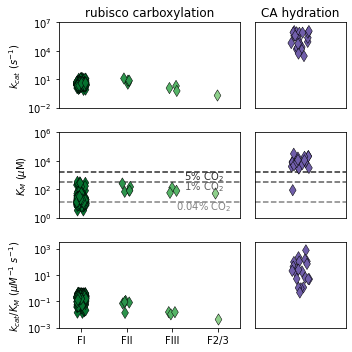

In [8]:
# Plot both distributions together
# rubisco forms
form_order = [1,2,'2_3',3]
form_labels = 'FI,FII,FIII,F2/3'.split(',')

fig, axs = plt.subplots(figsize=(5,5), ncols=2, nrows=3, gridspec_kw=dict(width_ratios=[2,1]))

# kcat panels
ylim = (1e-2,1e7)
plt.sca(axs[0,0])
plt.yscale('log')

sns.stripplot(data=rub_df, x='isoform', y='vC', order=form_order,
              marker='d', size=8, edgecolor='k', linewidth=0.5, palette=greens)

plt.ylabel('$k_{cat}$ ($s^{-1}$)', fontsize=10)
plt.title('rubisco carboxylation', fontsize=12)
plt.xticks([])
plt.xlabel('')
plt.ylim(*ylim)

plt.sca(axs[0,1])
plt.yscale('log')

form_order = [1,2,'2_3',3]
form_labels = 'FI,FII,FIII,F2/3'.split(',')
sns.stripplot(data=CA_df, y='kcat [s-1]',
              marker='d', size=8, edgecolor='k', linewidth=0.5, palette=purples[1:])
plt.title('CA hydration', fontsize=12)
plt.ylim(*ylim)
plt.ylabel('')
plt.xticks([])
plt.yticks([])

# KM panels
# Henry's law constant for CO2 @ 25 C.
Hcp = 3.4e-2
co2_conc_uM = lambda pct: 1e4*Hcp*pct
ylim = (1,1e6)

plt.sca(axs[1,0])
plt.yscale('log')
sns.stripplot(data=rub_df, x='isoform', y='KC', order=form_order,
              marker='d', size=8, edgecolor='k', linewidth=0.5, palette=greens)

for i, pct in enumerate([0.04,1,5]):
    cconc = co2_conc_uM(pct)
    plt.axhline(cconc, ls='--', color=greys[-i-4])
    plt.text(2.7, 0.3*cconc, '{0}% CO$_2$'.format(pct), color=greys[-i-4], ha='center')
plt.ylabel('$K_{M}$ ($\mu$M)', fontsize=10)
plt.xticks([])
plt.xlabel('')
plt.ylim(*ylim)

plt.sca(axs[1,1])
plt.yscale('log')
sns.stripplot(data=CA_df, y='KM (uM)',
              marker='d', size=8, edgecolor='k', linewidth=0.5, palette=purples[1:])
for i, pct in enumerate([0.04,1,5]):
    cconc = co2_conc_uM(pct)
    plt.axhline(cconc, ls='--', color=greys[-i-4])
plt.ylim(*ylim)
plt.ylabel('')
plt.xticks([])
plt.yticks([])

# kcat/KM panels
ylim = (1e-3,3e3)
plt.sca(axs[2,0])
plt.yscale('log')
sns.stripplot(data=rub_df, x='isoform', y='kon_C', order=form_order,
              marker='d', size=8, edgecolor='k', linewidth=0.5, palette=greens)

plt.ylabel('$k_{cat}$/$K_{M}$ ($\mu M^{-1}$ $s^{-1}$)', fontsize=10)
plt.xticks(np.arange(4), form_labels, fontsize=10)
plt.xlabel('')
plt.ylim(*ylim)

plt.sca(axs[2,1])
plt.yscale('log')
sns.stripplot(data=CA_df, y='kcat/KM (/s /uM)',
              marker='d', size=8, edgecolor='k', linewidth=0.5, palette=purples[1:])
plt.ylim(*ylim)
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('../figures/sup_fig_enzyme_kinetics/rub_ca_kin.png', facecolor='w', dpi=600)
plt.show()